In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

plt.rcParams["figure.figsize"] = (8,5)
np.random.seed(42)

print("Setup complete.")


Setup complete.


In [ ]:
df = pd.read_csv("/content/kaggle_housing.csv")

df.columns = df.columns.str.lower().str.replace(" ", "")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
binary_cols = [
    "mainroad",
    "guestroom",
    "basement",
    "hotwaterheating",
    "airconditioning",
    "prefarea"
]

for col in binary_cols:
    df[col] = df[col].map({"yes": 1, "no": 0})

df = pd.get_dummies(df, columns=["furnishingstatus"], drop_first=True)

print("After preprocessing shape:", df.shape)
df.head()


After preprocessing shape: (545, 14)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


In [ ]:
X = df.drop(columns=["price"])
y = np.log(df["price"])   # log scale for stability

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (408, 13)
Test size: (137, 13)


In [ ]:
models = {
    "Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "Tree": DecisionTreeRegressor(
        max_depth=6, random_state=42
    ),

    "Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        random_state=42
    ),

    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(C=50, gamma="scale"))
    ]),

    "Bayesian": Pipeline([
        ("scaler", StandardScaler()),
        ("model", BayesianRidge())
    ])
}

print("Models defined:", list(models.keys()))


Models defined: ['Linear', 'Tree', 'Forest', 'SVM', 'Bayesian']


In [ ]:
predictions = {}
metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)

    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_test)

    predictions[name] = y_pred

    metrics[name] = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

metrics_df = pd.DataFrame(metrics).T
metrics_df


,MAE,RMSE,R2
Linear,8.865683e+05,1.225654e+06,0.674013
Tree,1.188425e+06,1.820877e+06,0.280509
Forest,9.642998e+05,1.383434e+06,0.584681
SVM,1.072824e+06,1.482753e+06,0.522908
Bayesian,8.841699e+05,1.228313e+06,0.672597


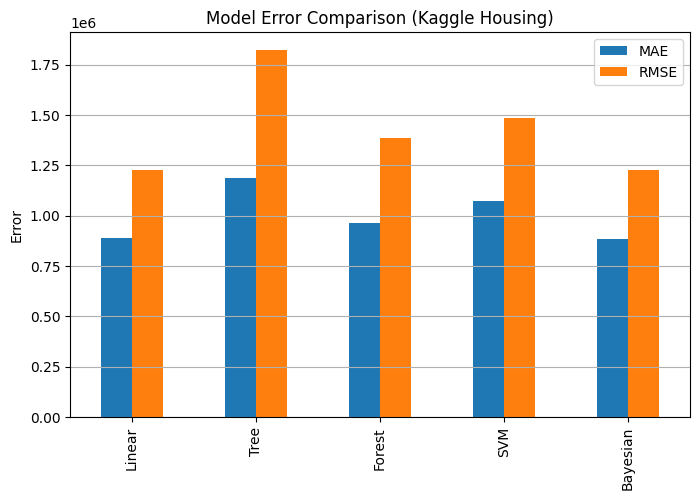

In [ ]:
metrics_df[["MAE","RMSE"]].plot(kind="bar")
plt.title("Model Error Comparison (Kaggle Housing)")
plt.ylabel("Error")
plt.grid(axis="y")
plt.show()


In [ ]:
pred_matrix = np.vstack(list(predictions.values()))
disagreement = np.var(pred_matrix, axis=0)

print("Disagreement variance computed.")


Disagreement variance computed.


In [ ]:
threshold = np.percentile(disagreement, 75)

mean_pred = np.mean(pred_matrix, axis=0)

disagreement_rank = np.sum(
    np.abs(pred_matrix - mean_pred) > threshold,
    axis=0
)

rank_counts = pd.Series(disagreement_rank).value_counts().sort_index()
rank_counts


,count
0,137


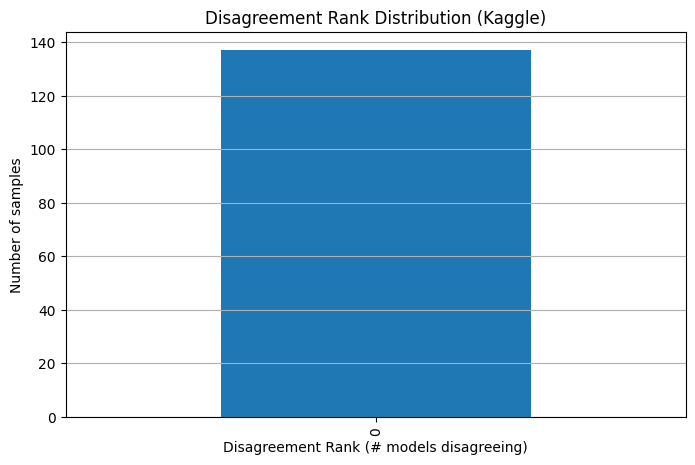

In [ ]:
rank_counts.plot(kind="bar")
plt.xlabel("Disagreement Rank (# models disagreeing)")
plt.ylabel("Number of samples")
plt.title("Disagreement Rank Distribution (Kaggle)")
plt.grid(axis="y")
plt.show()


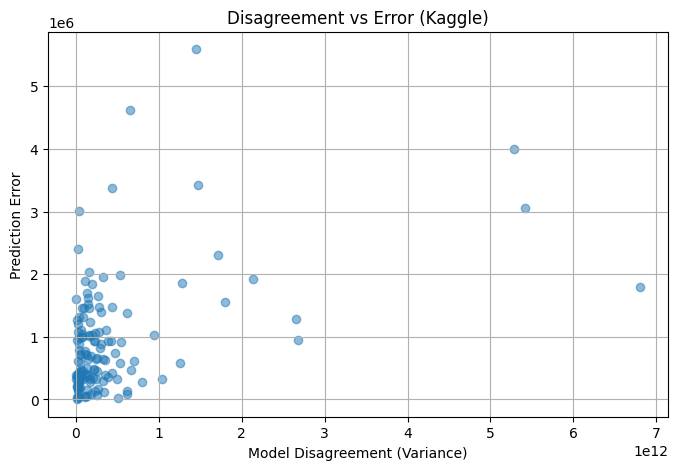

In [ ]:
avg_prediction = np.mean(pred_matrix, axis=0)
absolute_error = np.abs(avg_prediction - y_true.values)

plt.scatter(disagreement, absolute_error, alpha=0.5)
plt.xlabel("Model Disagreement (Variance)")
plt.ylabel("Prediction Error")
plt.title("Disagreement vs Error (Kaggle)")
plt.grid()
plt.show()


In [ ]:
error_threshold = np.percentile(absolute_error, 75)

error_sets = {}
for name, preds in predictions.items():
    error_sets[name] = set(
        np.where(np.abs(preds - y_true.values) > error_threshold)[0]
    )

overlap_matrix = pd.DataFrame(
    index=error_sets.keys(),
    columns=error_sets.keys()
)

for m1 in error_sets:
    for m2 in error_sets:
        overlap_matrix.loc[m1, m2] = len(
            error_sets[m1].intersection(error_sets[m2])
        )

overlap_matrix


,Linear,Tree,Forest,SVM,Bayesian
Linear,33,21,26,23,33
Tree,21,49,33,23,21
Forest,26,33,45,29,26
SVM,23,23,29,44,23
Bayesian,33,21,26,23,33


In [ ]:
top_idx = np.argsort(disagreement)[-5:]

print("Top 5 High-Disagreement Samples:\n")
for idx in top_idx:
    print("True Price:", round(y_true.values[idx],2))
    for i, model_name in enumerate(predictions.keys()):
        print(f"  {model_name}: {round(pred_matrix[i, idx],2)}")
    print("-"*45)


Top 5 High-Disagreement Samples:

True Price: 9681000.0
  Linear: 8628621.99
  Tree: 10850000.0
  Forest: 8237807.27
  SVM: 5721279.8
  Bayesian: 8557352.58
---------------------------------------------
True Price: 6615000.0
  Linear: 8494265.61
  Tree: 4690000.0
  Forest: 6922440.96
  SVM: 9359245.45
  Bayesian: 8377822.32
---------------------------------------------
True Price: 3920000.0
  Linear: 6361954.96
  Tree: 12250000.0
  Forest: 8345069.74
  SVM: 6310048.03
  Bayesian: 6341496.3
---------------------------------------------
True Price: 9100000.0
  Linear: 4914005.8
  Tree: 10612101.58
  Forest: 5568112.72
  SVM: 4179512.2
  Bayesian: 4922535.62
---------------------------------------------
True Price: 6300000.0
  Linear: 6915221.71
  Tree: 12250000.0
  Forest: 9697094.51
  SVM: 4730835.19
  Bayesian: 6879194.94
---------------------------------------------
